# 锚框



| 参数                | 含义             | 示例              |
| ----------------- | -------------- | --------------- |
| **`precision=2`** | 小数点后保留2位       | `3.1416 → 3.14` |
| `linewidth=100`   | 每行最多字符数        | 防止一行过长          |
| `threshold=1000`  | 超过1000个元素时省略显示 | 避免打印大Tensor刷屏   |
| `edgeitems=3`     | 每维开头/结尾显示3个元素  | 平衡详情与简洁         |


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)

锚框的宽度和高度分别是$hs\sqrt{r}$和$hs/\sqrt{r}$。
我们只考虑
组合：

$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1)$$

In [2]:
'''
data：输入特征图（shape: [batch, channels, height, width]）
sizes：锚框的尺度列表（如 [0.2, 0.5] 表示占特征图20%、50%）
ratios：锚框的宽高比列表（如 [1, 2, 0.5]）
'''
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    # 1. 获取特征图尺寸
    # 切片：从倒数第2个元素取到末尾，无论前面多少维度，只关心最后两个空间维度
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    # 2. 计算每个像素点的锚框数量
    # 生成逻辑：
    # 每个size配第1个ratio → 2个框: [0.2×1, 0.5×1]
    # 第1个size配其余ratios → 2个框: [0.2×2, 0.2×0.5]
    # 总计：2 + 2 = 4个框
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # 3. 生成像素中心点网格（归一化坐标）
    offset_h, offset_w = 0.5, 0.5 # 锚框中心对齐像素中心
    steps_h = 1.0 / in_height # 垂直步长：1/8=0.125
    steps_w = 1.0 / in_width # 水平步长：1/8=0.125
    '''
    torch.arange(in_height, device=device)生成从 0 到 in_height-1 的整数序列
    + offset_h (offset_h = 0.5)将坐标从像素左上角偏移到像素中心
    * steps_h (steps_h = 1.0 / in_height = 0.125)归一化到 [0,1]区间
    '''
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    '''
    shift_y = tensor([[0.0625, 0.0625, ..., 0.0625],  # 第0行全部重复0.0625
                  [0.1875, 0.1875, ..., 0.1875],  # 第1行全部重复0.1875
                  ...
                  [0.9375, 0.9375, ..., 0.9375]]) # 第7行全部重复0.9375
    shape: (8, 8)

    shift_x = tensor([[0.0625, 0.1875, ..., 0.9375],  # 第0行=center_w
                    [0.0625, 0.1875, ..., 0.9375],  # 第1行=center_w
                    ...
                    [0.0625, 0.1875, ..., 0.9375]]) # 第7行=center_w
    shape: (8, 8)
    indexing='ij' 表示矩阵索引（i=行索引，j=列索引），与图像(height, width)坐标系一致。
    '''
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij') # 将两个1D坐标向量扩展成2D网格矩阵
    # reshape(-1) 展平操作，将8×8矩阵展平成64×1向量，方便后续向量化计算
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    '''
    4. 计算锚框的宽高（归一化）
    sizes=[0.2, 0.5], ratios=[1, 2, 0.5], in_height=in_width=8
    宽度公式：size * sqrt(ratio)
    √(ratio_tensor[0]) = √1 = 1
    size_tensor * √(ratio_tensor[0]) = [0.2×1, 0.5×1] = [0.20, 0.50]
    √(ratio_tensor[1:]) = √[2, 0.5] = [1.41, 0.71]
    sizes[0] * √(ratio_tensor[1:]) = 0.2 × [1.41, 0.71] = [0.28, 0.14]
    拼接后：w = [0.20, 0.50, 0.28, 0.14]
    '''
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), # 第一部分：所有size × √(r₀)
                   # 第二部分：只有s₀ × √(r₁...rₘ)
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width # 宽高归一化修正
    # 高度公式：size / sqrt(ratio)
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    '''
    [ -w/2,  -h/2,  w/2,  h/2 ]
       ↓      ↓      ↓     ↓
      左    上    右    下
    5. 生成锚框偏移量
    将[w,h]转为[-w,-h,w,h]并重复64次，除以2是因为后面要加到中心点上
    torch.stack((-w, -h, w, h))：将负宽、负高、正宽、正高堆叠成一个矩阵
    .T 转置
    .repeat(in_height * in_width, 1)：在第一个维度上重复64次（8×8特征图有64个像素点）
    / 2：除以2得到半宽半高
    '''
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2
    '''
    6. 组装最终锚框
    每个中心点重复4次，对应4个锚框
    shape: (64*4, 4) = (256, 4)
    torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1)：将x、y坐标堆叠成 [x, y, x, y] 格式的矩阵
    为什么重复4次？ 因为后续要直接加上4个锚框的偏移量 [-w/2, -h/2, w/2, h/2]，格式需要对应
    .repeat_interleave(boxes_per_pixel, dim=0)：将每一行重复4次（因为每个像素有4个锚框）
    repeat_interleave：逐行重复（每行重复4次）
    repeat：整体重复（整个矩阵重复4次）
    '''
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    # 中心点 + 宽高偏移 = 最终锚框坐标
    output = out_grid + anchor_manipulations
    # 总锚框数 = 特征图像素数 × 每像素锚框数
    return output.unsqueeze(0)

返回的锚框变量`Y`的形状

In [3]:
img = d2l.plt.imread('../img/catdog.jpg')
# # 取前两个元素：高度和宽度
h, w = img.shape[:2]

print(h, w)
# 1: batch size，3: 3通道 (RGB)，h, w: 图像高和宽
X = torch.rand(size=(1, 3, h, w))
'''
sizes: 3个尺度（占特征图的75%、50%、25%）
ratios：3个宽高比（1:1, 2:1, 1:2）
总像素数 = 256 × 256 = 65,536
每个像素锚框数 = len(sizes) + len(ratios) - 1
总锚框数 = 65,536 × 5 = 327,680
计算: boxes_per_pixel = 3 + 3 - 1 = 5（每个像素生成5个锚框）
'''
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

231 294


torch.Size([1, 339570, 4])

访问以（250,250）为中心的第一个锚框

In [5]:
'''
h：高度（特征图的行数）
w：宽度（特征图的列数）
5：每个位置有 5 个候选框（anchor boxes）
4：每个框用 4 个坐标值表示（通常是[x_min,y_min,x_max,y_max]或[center_x,center_y,width,height]）
'''
boxes = Y.reshape(h, w, 5, 4)
'''
索引操作：提取特征图 (200, 200) 位置上的第0个候选框的全部4个坐标值
各索引含义：
200：第 200 行
200：第 200 列
0：5个框中的第 0 个
:：冒号表示切片，取该框的所有4个坐标
'''
boxes[200, 200, 0, :]
# boxes[250, 250, 0, :]

tensor([0.39, 0.49, 0.98, 1.24])

显示以图像中以某个像素为中心的所有锚框

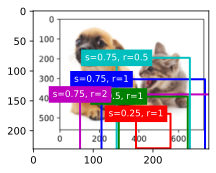

In [7]:
'''
axes: Matplotlib的绘图轴对象
bboxes: 边界框数组，形状一般为 (n, 4)，每行是一个框[x,y,w,h]或[xmin, ymin, xmax, ymax]
labels: 可选，标签列表
colors: 可选，颜色列表
'''
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    # 作用：将非列表对象转换为列表，若为 None 则使用默认值
    # 用途：统一处理输入参数，支持单个值或列表
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    # 将labels转为列表（若无则保持 None）
    labels = _make_list(labels)
    # 将colors转为列表，默认使用5种颜色 ['b', 'g', 'r', 'm', 'c']
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)] # 循环使用颜色
        '''
        bbox.detach()：从计算图中分离张量，停止梯度追踪
        为什么需要：原始bbox可能是需要计算梯度的Tensor（训练时需要），但绘图不需要梯度，且会报错。
        detach()创建一个不需要梯度的新张量
        2. .numpy()：将 PyTorch 张量转换为NumPy数组
        为什么需要：d2l.bbox_to_rect() 函数内部使用Matplotlib，而 Matplotlib 只接受 NumPy 数组格式的数据
        3. d2l.bbox_to_rect()
        作用  ：将边界框坐标 [x, y, w, h] 转换为 Matplotlib 的 Rectangle 补丁对象
        输入：
        边界框坐标（NumPy 数组）
        颜色字符串（如 'b', 'g', 'r' 等）
        输出：一个 matplotlib.patches.Rectangle 对象，可直接添加到图像上绘制
        '''
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color) # 转为矩形
        axes.add_patch(rect) # 添加矩形到画布
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h)) # 缩放因子
fig = d2l.plt.imshow(img)
'''
boxes[200, 200, :, :]：从(h, w, 5, 4)数组中提取坐标(200, 200)位置返回形状为(5, 4)的数组，即该位置的5个候选框
bbox_scale：bbox_scale = (w, h, w, h)是图像宽高
将归一化的框坐标 缩放到原始图像尺寸（像素单位）
标签含义：s=0.75, r=1表示尺度 0.75，宽高比1:1，分别对应5个不同大小/比例的anchor boxes
'''
show_bboxes(fig.axes, boxes[200, 200, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])
# show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
#             ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
#              's=0.75, r=0.5'])

交并比（IoU）

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$

In [8]:
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    '''
    1. 计算每个框的面积 (宽 × 高) = (x2 - x1) × (y2 - y1)
    boxes[:, 0] = x1（左上角x坐标）
    boxes[:, 1] = y1（左上角y坐标）
    boxes[:, 2] = x2（右下角x坐标）
    boxes[:, 3] = y2（右下角y坐标）
    '''
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) * # x2 - x1
                              (boxes[:, 3] - boxes[:, 1])) # y2 - y1
    areas1 = box_area(boxes1) # boxes1所有框的面积，形状: (N,)
    areas2 = box_area(boxes2) # boxes2所有框的面积，形状: (M,)
    '''
    2. 计算交集区域的坐标
    boxes1[:, None, :2]增加维度，boxes1形状: (N, 4)→boxes1[:, :2]形状: (N, 2)
    None在第1维插入新维度→形状变为 (N, 1, 2)
    目的：为广播做准备，让每个boxes1中的框能与所有boxes2中的框比较
    torch.max：逐元素取最大值
    广播后两个张量形状都变为 (N, M, 2)，在最后一维（坐标维）逐元素比较
    逻辑：交集的左上角必须是两个框中更靠右和更靠下的点，所以要取最大值
    '''
    inter_upperlefts = torch.max(boxes1[:, None, :2], # 形状:(2,1,2) →自动扩展为(2,3,2)
                                 # 形状: (3, 2)→自动扩展为(2,3,2)
                                 boxes2[:, :2]) # 交集左上角 (x1,y1)
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:]) # 交集右下角 (x2, y2)
    '''
    3.  计算交集的宽和高，负数变0（表示无重叠）（右下角 - 左上角）
    计算交集的宽度 = x2 - x1
    计算交集的高度 = y2 - y1
    结果形状：(N, M,2)，最后一维是 [width,height]
    .clamp(min=0)  ：将负数变为 0
    为什么需要？当两个框没有重叠时，inter_lowerrights会小于inter_upperlefts，相减得到负数
    作用：无重叠时，宽高设为 0，后续计算的交集面积也为0
    '''
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    '''
    4. 计算交集面积
    inters形状：(N, M, 2)
    N：boxes1中的框数量，M：boxes2中的框数量，最后一维 2：分别存储宽度和高度
    inters[:, :, 0]：提取所有交集的宽度，形状：(N, M)
    inters[:, :, 1]：提取所有交集的高度，形状：(N, M)
    相乘得到面积，结果inter_areas 形状：(N, M)
    inter_areas[i, j]表示boxes1[i]和boxes2[j]的交集面积
    '''
    inter_areas = inters[:, :, 0] * inters[:, :, 1] # 宽 × 高，形状: (N, M)
     # 5. 计算并集面积 = area1 + area2 - 交集面积
    union_areas = areas1[:, None] + areas2 - inter_areas # 形状: (N, M)
    # 6. 返回IoU值
    return inter_areas / union_areas # 形状: (N, M)

In [1]:
import torch
# 创建一个3×4×5的张量
x = torch.randn(3, 4, 5)
x[:, :]      # 选择所有第0维和所有第1维 → 形状仍为 (3, 4, 5)
x[:, :, :]   # 同上，选择所有三个维度 → 形状 (3, 4, 5)
x[:, 0]      # 选择所有第0维，但只取第1维的第0个元素 → 形状 (3, 5)
x[0, :, :]   # 只取第0维的第0个元素 → 形状 (4, 5)
x[:, 0:2, :] # 选择第0维所有，第1维的0~2（不含2），第2维所有 → 形状 (3, 2, 5)
inters = torch.randn(2, 3, 4)
# 在代码中
inters[:, :, 0]  # 选择所有N和M，只取最后一维的第0个元素（宽度）

tensor([[ 0.9686, -0.0926,  0.9838],
        [ 0.3275,  1.8982, -1.3105]])

将真实边界框分配给锚框

在目标检测中，背景指不包含任何目标物体的图像区域，在代码中用 -1 标记

在PyTorch 中，(num_anchors,)是表示形状（shape）的元组（tuple），特指一个单元素元组<br>
关键：末尾的逗号
```python
# 注意末尾的逗号！
shape = (num_anchors,)  # 这是一个包含1个元素的元组: (N,)
# 对比：没有逗号就不是元组
not_a_tuple = (num_anchors)  # 这只是一个整数 N
```
为什么必须加逗号？<br>
在Python中，单元素元组必须带末尾逗号，否则括号会被当作普通分组符号，而不是元组构造符。
```python
# 示例
print(type((5)))    # <class 'int'>  (不是元组！)
print(type((5,)))   # <class 'tuple'> (这才是元组)
```
在PyTorch中的用途:这个元组用于指定张量的形状（shape）
```python
# 创建一个形状为 (num_anchors,) 的1D张量
col_discard = torch.full((num_anchors,), -1)  # shape: [num_anchors]
# 等价写法
col_discard = torch.full((5,), -1)  # 创建: tensor([-1, -1, -1, -1, -1])
# 创建2D张量需要两个元素
row_discard = torch.full((num_gt_boxes, 3), -1)  # shape: [num_gt_boxes, 3]
```



In [9]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    # anchors.shape[0]：获取锚框的总数（如：8192个锚框）
    # ground_truth.shape[0]：获取真实边界框的数量（如：3个目标）
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 计算所有锚框与所有真实框的IoU矩阵，形状为(num_anchors, num_gt_boxes)
    jaccard = box_iou(anchors, ground_truth)
    '''
    创建一个长度为num_anchors的张量，初始值全为-1，记录每个锚框最终匹配到的真实框索引
    anchors_bbox_map[i] = j表示锚框i被分配给真实框j；-1表示该锚框未匹配任何真实框（背景或忽略）
    参数：(num_anchors,)：形状；-1：填充值
    dtype=torch.long：整数类型，适合存储索引；device=device：指定设备（CPU/GPU）
    '''
    # 初始化映射数组，长度为锚框数，初始值为-1（表示未匹配）
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # 对每个锚框，找到其IoU最大的真实框：max_ious存IoU值，indices存真实框索引
    max_ious, indices = torch.max(jaccard, dim=1)
    # 筛选出IoU≥阈值的锚框索引
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    # 获取这些锚框对应的真实框索引
    box_j = indices[max_ious >= iou_threshold]
    # 将满足阈值的锚框分配给对应的真实框
    anchors_bbox_map[anc_i] = box_j
    '''
    创建两个填充数组，用于"屏蔽"已匹配的行/列
    torch.full(..., -1): 创建用-1填充的张量，作为丢弃标记
    col_discard  : 用于屏蔽IoU矩阵的列（对应ground-truth框）
    row_discard  : 用于屏蔽IoU矩阵的行（对应anchor框）
    为什么用 -1？IoU 值范围是 [0, 1]，-1 是无效值
    torch.argmax() 在存在非负值时永远不会选择-1
    这是一种贪心匹配策略，确保：每个ground-truth框至少分配到一个anchor，已分配的anchor和GT框不会被重复匹配
    '''
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    # 循环找出当前IoU矩阵中最大的值，并计算其行列索引
    # 循环num_gt_boxes次，意味着最多为每个GT框分配一个 anchor（如果还有剩余的话）
    for _ in range(num_gt_boxes):
        '''
        jaccard是IoU矩阵，形状为[num_anchors,num_gt_boxes]
        torch.argmax()返回展平（flatten）后的最大值的索引，每次迭代都找当前未被屏蔽的最大IoU匹配对
        '''
        max_idx = torch.argmax(jaccard)
        # 取模运算(%)得到列索引（对应哪个GT框）；整除运算(//)得到行索引（对应哪个anchor）；.long()转为整数类型
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        # 强制分配：即使IoU低于阈值，也要为每个真实框分配最佳锚框
        # 将选中的anchor（anc_idx）分配给对应的GT框（box_idx）；anchors_bbox_map记录每个anchor匹配到的GT框编号
        anchors_bbox_map[anc_idx] = box_idx
        '''
        col_discard和row_discard都是全-1张量
        将该 GT 框所在的整列设为 -1 → 这个 GT 框不会再被分配给其他 anchor
        将该 anchor 所在的整行设为 -1 → 这个 anchor 不会再被分配给其他 GT 框
        效果：从矩阵中"擦除"已匹配的行和列
        '''
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    # 返回最终映射数组，值表示每个锚框匹配的真实框索引（-1表示未匹配）
    return anchors_bbox_map

给定框$A$和$B$，中心坐标分别为$(x_a, y_a)$和$(x_b, y_b)$，宽度分别为$w_a$和$w_b$，高度分别为$h_a$和$h_b$，可以将$A$的偏移量标记为：

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right)$$

| 列索引    | 0         | 1         | 2            | 3            |
| ------ | --------- | --------- | ------------ | ------------ |
| **内容** | 中心x       | 中心y       | 宽度w          | 高度h          |
| **切片** | `[:, :2]` | `[:, :2]` | **\[:, 2:]** | **\[:, 2:]** |


In [10]:
'''
anchors:锚框，形状 (num_anchors, 4)，格式为角点坐标 (x_min, y_min, x_max, y_max)
assigned_bb:分配给锚框的真实边界框，格式相同
eps:防止除零/对数计算出错的小常数
'''
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    '''
    [:,:2]:提取中心点(cx,cy)
    计算相对偏移：(gt_center - anchor_center) / anchor_size
    除以宽高：使偏移量具有尺度不变性；乘以10：缩放系数，平衡中心偏移与宽高偏移的损失贡献
    '''
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    '''
    [:,2:]: 提取宽高 (w, h)
    计算尺度比：gt_size / anchor_size；对数变换：log(gt/anchor)，将乘法变加法，数值更稳定
    eps: 防止取对数时出现0或负数；乘以5：缩放系数
    '''
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    # 将中心偏移(dx,dy)和宽高偏移(dw, dh)拼接为完整偏移量
    offset = torch.cat([offset_xy, offset_wh], axis=1) # 列拼接
    return offset

标记锚框的类别和偏移量

| anchor索引           | 0         | 1  | 2         | 3  | 4         |
| ------------------ | --------- | -- | --------- | -- | --------- |
| `anchors_bbox_map` | 2         | -1 | 0         | -1 | 1         |
| `class_labels`     | **3**     | 0  | **1**     | 0  | **2**     |
| `assigned_bb`      | **GT2坐标** | 0  | **GT0坐标** | 0  | **GT1坐标** |
| `offset`           | **非零值**   | 0  | **非零值**   | 0  | **非零值**   |
| `bbox_mask`        | **1**     | 0  | **1**     | 0  | **1**     |


| 方法              | 行为          | 结果形状                            |
| --------------- | ----------- | ------------------------------- |
| `torch.stack()` | **新增**一个维度  | `(batch_size, num_anchors*4)`   |
| `torch.cat()`   | **沿现有**维度拼接 | `(num_anchors*4*batch_size,)` ❌ |


In [11]:
'''
GT框 + 锚框 
   ↓
assign_anchor_to_bbox → 分配映射
   ↓
生成掩码（正/负样本）
   ↓
填充类别和坐标（背景保持0）
   ↓
计算偏移量
   ↓
屏蔽背景 → 最终训练目标
'''
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    '''
    1. 初始准备
    移除anchors的batch维度→(num_anchors,4)；从(1,num_anchors,4)→(num_anchors,4)
    labels.shape[0]：批次大小（batch size），即多少个样本
    anchors.squeeze(0)：移除第0维（通常是batch维）
    anchors更新后的变量，现在只保留锚框坐标
    为什么需要 squeeze(0)？
    输入的 anchors 可能带了 batch 维度 (1,num_anchors, 4)但在循环内需要处理每个样本，锚框是共享的，所以提前压缩
    '''
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    '''
    2. 初始化存储列表
    batch_offset:存储每个样本的回归偏移量
    batch_mask:存储每个样本的掩码（哪些anchor参与回归）
    batch_class_labels:存储每个样本的类别标签
    在循环中逐步收集结果，最后用 torch.stack()合并
    '''
    batch_offset, batch_mask, batch_class_labels = [], [], []
    '''
    anchors.device:设备（CPU/GPU），确保后续张量在同一设备
    anchors.shape[0]:锚框数量（num_anchors），在squeeze后是第0维大小
    num_anchors:后续创建张量需要知道锚框总数
    '''
    device, num_anchors = anchors.device, anchors.shape[0]
    # 3. 循环处理每个样本
    for i in range(batch_size):
        # labels 形状: (batch_size, num_gt_boxes, 5)
        # 5 = [类别, x_min, y_min, x_max, y_max]
        label = labels[i, :, :] # 取第i个样本的GT框: (num_gt, 5)
        '''
        4. 锚框分配
        anchors: 所有锚框 → (num_anchors, 4)
        -1:  背景  （未分配任何GT框）
        label[:, 1:]: GT框坐标，忽略类别列；返回值: 映射数组，形状 (num_anchors,)
        >0: 分配的GT框索引；-1: 背景（未分配）
        '''
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        '''
        5. 创建掩码
        anchors_bbox_map >= 0:布尔掩码，哪些是正样本
        .float():转为0/1浮点数；.unsqueeze(-1):形状从(num_anchors,)→(num_anchors,1)
        .repeat(1, 4):复制为 (num_anchors, 4)，每列相同
        作用：屏蔽背景anchor的损失，只有正样本参与回归损失计算
        '''
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        '''
        6. 初始化标签和坐标
        全0初始化：0 代表背景类别；dtype=torch.long: 类别索引是整数；后续填充：正样本位置会被赋值为真实类别
        为什么先初始化为0？
        背景anchor不需要回归目标：坐标保持0，乘以bbox_mask后偏移量也是0，背景anchor类别为0：符合背景类别索引定义
        统一数据结构：所有anchor都有对应条目，方便向量化计算
        '''
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device) # 全0 → 默认背景类别
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device) # 未分配的anchor坐标保持0
        """
        7. 填充正样本信息
        anchors_bbox_map形状: (num_anchors,)：示例:[2,-1,0,-1,1] (5个anchor，其中3个被分配)
        torch.nonzero() 返回所有非负值的索引，形状 (num_pos,1)；结果: tensor([[0], [2], [4]])
        """
        indices_true = torch.nonzero(anchors_bbox_map >= 0) # 正样本索引
        '''
        用正样本索引去映射数组中取对应的GT框编号
        结果: tensor([2, 0, 1]) (3个正样本分别对应GT框2、0、1)
        若GT框0的类别是0(人), GT框1的类别是1(车), GT框2的类别是2(狗)
        平移后: class_labels = [3, 0, 1, 0, 2]  (0=背景)
        '''
        bb_idx = anchors_bbox_map[indices_true]
        # label[bb_idx,0]:GT框的原始类别（从0开始）为什么+1？：0保留给背景，真实类别从1开始编号
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        # label[bb_idx, 1:] 提取GT框的4个坐标 (第1-4列)；将坐标填入对应正样本anchor的位置，背景位置保持0
        assigned_bb[indices_true] = label[bb_idx, 1:]
        '''
        8. 计算偏移量
        offset_boxes() 计算所有anchor的偏移量 (包括背景)
        * bbox_mask: 背景anchor的偏移量被强制置0
        bbox_mask 在正样本位置为1，背景位置为0
        '''
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        # 9. 收集批次数据（动态收集）
        # .reshape(-1) 展平为一维，方便后续计算损失；class_labels不展平，因为类别损失独立计算
        batch_offset.append(offset.reshape(-1)) # 展平为(num_anchors*4,)
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)  # 保持(num_anchors,)
    '''
    10. 堆叠批次结果（stack合并）
    输入: [offset_sample1,offset_sample2, ...]，每个offset_sample形状:(num_anchors*4,)（已展平）
    输出: (batch_size, num_anchors*4)；例: (32, 8732) (SSD中8732个anchor)
    输入: [mask_sample1,mask_sample2, ...]，每个mask_sample形状: (num_anchors*4,)
    输出: (batch_size, num_anchors*4)，与 bbox_offset 一一对应，标记哪些是正样本
    输入: [labels_sample1,labels_sample2, ...]，每个labels_sample形状: (num_anchors,)（未展平）
    输出: (batch_size, num_anchors)；例: (32, 8732)
    注意: 类别标签不需要展平，因为后续计算分类损失时保持2D更方便。
    '''
    bbox_offset = torch.stack(batch_offset) # (batch_size, num_anchors*4)
    bbox_mask = torch.stack(batch_mask) # (batch_size, num_anchors*4)
    class_labels = torch.stack(batch_class_labels) # (batch_size, num_anchors)
    '''
    bbox_offset(batch, num_anchors*4)：回归目标（已屏蔽背景）
    bbox_mask(batch, num_anchors*4)：1=正样本，0=背景
    class_labels(batch, num_anchors)：类别标签（0=背景）
    '''
    return (bbox_offset, bbox_mask, class_labels)

在图像中绘制这些真实边界框和锚框

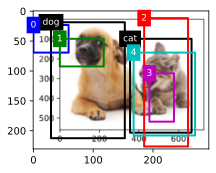

In [12]:
'''
格式:[类别,x_min,y_min,x_max,y_max]
坐标:已归一化到[0,1]范围
两个目标:0=狗, 1=猫
'''
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92], # 第1个框: 类别0(dog), 坐标...
                         [1, 0.55, 0.2, 0.9, 0.88]]) # 第2个框: 类别1(cat), 坐标...
# 格式: [x_min, y_min, x_max, y_max]；5个锚框: 手动预设的不同位置和大小
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
'''
ground_truth[:, 1:]: 去掉类别列，只保留坐标；* bbox_scale: 将归一化坐标还原为像素坐标
若 bbox_scale = 500，则 0.1 → 50像素；['dog', 'cat']: 每个框的标签文字；'k': 黑色实线框
'''
show_bboxes(fig.axes, 
            ground_truth[:, 1:] * bbox_scale, # 去掉类别列，并缩放
            ['dog', 'cat'], # 类别标签
            'k') # 颜色：黑色('k'=black)
'''
anchors * bbox_scale: 同样转换为像素坐标
['0', '1', '2', '3', '4']: 显示锚框编号
颜色: 默认使用不同颜色（或自动配色）
'''
show_bboxes(fig.axes, anchors * bbox_scale, # 锚框坐标缩放
            ['0', '1', '2', '3', '4']); # 锚框编号

根据狗和猫的真实边界框，标注这些锚框的分类和偏移量

In [13]:
'''
因为multibox_target要求输入有batch维度，所以用unsqueeze(0)在第0维增加一个维度
multibox_target 的返回值：该函数返回一个元组：labels 是一个包含3个元素：
labels[0]:回归偏移量 (batch, num_anchors*4)
labels[1]:掩码 (batch, num_anchors*4)
labels[2]:类别标签 (batch, num_anchors)
'''

labels = multibox_target(anchors.unsqueeze(dim=0), # (5,4) → (1,5,4)  增加batch维度
                         ground_truth.unsqueeze(dim=0)) # (2,5) → (1,2,5)  增加batch维度
'''
形状: (1, num_anchors) = (1, 5)；内容: [背景/目标类别]，其中：
0: 背景（未分配的anchor）；>0: 分配到的目标类别索引（从1开始）
'''
labels[2] # 取出 class_labels

tensor([[0, 1, 2, 0, 2]])

In [14]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [15]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

应用逆偏移变换来返回预测的边界框坐标

In [16]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    '''
    1. 转换锚框格式
    将输入的anchors从角点坐标(x_min,y_min,x_max,y_max)转换为中心坐标(cx,cy,w,h)，这是为了与偏移量的计算方式对齐
    '''
    anc = d2l.box_corner_to_center(anchors)
    '''
    2. 解码中心点坐标
    逆运算（对应 offset_boxes 的第1步）：
    训练编码: offset_xy = 10 * (gt_xy - anc_xy) / anc_wh
    预测解码: pred_xy = (offset_xy * anc_wh / 10) + anc_xy
    参数：
    offset_preds[:, :2]: 模型预测的中心点偏移量 (dx, dy)
    anc[:, 2:]: 锚框的宽高 (w, h)
    / 10: 缩放系数的逆运算
    + anc[:, :2]: 加回锚框中心点 (cx, cy)
    '''
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    '''
    3. 解码宽高
    逆运算（对应 offset_boxes 的第2步）：
    训练编码: offset_wh = 5 * log(gt_wh / anc_wh)
    预测解码: pred_wh = exp(offset_wh / 5) * anc_wh
    参数：
    offset_preds[:, 2:]: 模型预测的宽高偏移量 (dw, dh)
    / 5: 缩放系数的逆运算
    torch.exp(...): 对数变换的逆运算
    * anc[:, 2:]: 乘以锚框的原始宽高
    '''
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    # 4. 合并中心点和宽高
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    '''
    5. 转回角点坐标
    将中心坐标 (cx, cy, w, h) 转换回 角点坐标 (x_min, y_min, x_max, y_max)，这是模型输出的最终预测框格式
    '''
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

以下`nms`函数按降序对置信度进行排序并返回其索引

# 算法流程图

输入: boxes[5], scores[5], threshold=0.5

初始化: B = [4,2,0,3,1] (按scores排序)
keep = []

循环1: 选B[0]=4, keep=[4]
       计算box4与[2,0,3,1]的IoU → [0.1, 0.9, 0.3, 0.4]
       保留IoU<=0.5的 → [0,2,3] → 对应索引[0,2,3]
       B = B[[0,2,3] + 1] = [2, 3, 1]

循环2: 选B[0]=2, keep=[4,2]
       计算box2与[3,1]的IoU → [0.05, 0.8]
       保留[0] → B = B[[0] + 1] = [3]

循环3: 选B[0]=3, keep=[4,2,3]
       只剩一个框 → 退出

返回: tensor([4, 2, 3])

复杂度

时间: O(N²) 因为每个保留下来的框都要与剩余框计算IoU

空间: O(N) 存储索引和IoU矩阵

实际应用中，会使用更高效的变体（如Soft-NMS, DIoU-NMS）来提升性能。

1、boxes[i, :]

boxes 形状: (num_boxes, 4)

i: 一个整数（标量索引）

boxes[i, :]      # 取第 i 行的所有列

等价于: boxes[i] 或 boxes[i, :] 或 boxes[i, 0:4]

结果形状: (4,)

```python
boxes = torch.tensor([[10,10,20,20],
                      [15,15,25,25],
                      [30,30,40,40]])
i = 1
boxes[i, :]      # tensor([15, 15, 25, 25])
```
2、boxes[B[1:], :]

B: 一维张量，存储框的索引，如 tensor([2, 0, 3, 1])

B[1:]: 切片，取从索引1开始到末尾: tensor([0, 3, 1])

boxes[B[1:], :]  # 取 B[1:] 中所有索引对应的行，所有列

结果形状: (len(B)-1, 4)
```python
B = torch.tensor([2, 0, 3, 1])
boxes[B[1:], :]  # 等价于 torch.cat([boxes[0], boxes[3], boxes[1]])
```
结果形状: (3, 4)  # 取出第0、3、1行的所有列

3、.reshape(-1, 4)
```python
boxes[i, :].reshape(-1, 4)     # (4,) → (1, 4)
boxes[B[1:], :].reshape(-1, 4) # (N-1, 4) → (N-1, 4)  # 形状不变
```
-1: 自动推断该维度大小

目的: 确保输入 box_iou 的形状为 (N, 4)

In [17]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    '''
    1. 按置信度降序排序
    scores: 每个预测框的置信度分数，形状 (num_boxes,)
    torch.argsort: 返回排序后的索引（不是分数本身）
    descending=True: 降序排列（分数高的在前）
    结果: B 是按置信度从高到低的框索引列表
    '''
    B = torch.argsort(scores, dim=-1, descending=True)
    # 2. 初始化保留列表
    keep = []
    '''
    3. 贪心循环
    B.numel(): B 中剩余元素个数；循环直到所有框都被处理（被保留或移除）
    '''
    while B.numel() > 0:
        # 4. 选择当前置信度最高的框
        # 每次循环都选剩余框中置信度最高的那个，确定保留：这个框一定不会被抑制
        i = B[0] # 取出剩余框中置信度最高的索引
        keep.append(i) # 加入保留列表
        # 5. 退出条件
        if B.numel() == 1: break # 如果只剩下一个框，直接退出循环（已经加入了keep）
        '''
        6. 计算IoU（核心）
        boxes[i,:]:当前最高置信度框（形状(4,)）
        boxes[B[1:], :]:剩余所有其他框（形状(num_remain-1,4)）
        box_iou(...):计算两两之间的IoU，返回形状(1,num_remain-1)
        .reshape(-1):展平为(num_remain-1,)
        结果: iou 是当前框与每个剩余框的IoU值数组
        '''
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        '''
        7. 保留低IoU的框
        iou <= iou_threshold: IoU小于阈值的框（不重叠的）
        torch.nonzero: 返回满足条件的索引
        结果: inds 是与当前框重叠不严重的剩余框的相对索引
        '''
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        '''
        8. 更新剩余框集合
        B[1:]: 剩余框索引是从第1个开始（第0个已处理）
        inds: 是相对索引[0, 2]，对应B[1:]中的位置
        + 1: 转换回在B中的真实索引
        B = ...: 保留未重叠的框，移除高IoU的框
        B = [2, 0, 3, 1]      # 当前所有框索引（按置信度）
        i = 2                 # 选第2个框（最高）
        B[1:] = [0, 3, 1]     # 剩余框
        iou = [0.85, 0.3]     # 与框0和框1的IoU
        inds = [1]            # 只有索引1的IoU<=0.5
        B = B[inds + 1] = B[[2]] = [1]  # 下一轮只处理框1
        '''
        B = B[inds + 1]
    # 9. 返回结果
    # keep: 保留的框索引列表，如 [2, 0, 1]，转换为张量并确保与输入同设备（CPU/GPU）
    return torch.tensor(keep, device=boxes.device)

将非极大值抑制应用于预测边界框

In [18]:
'''
模型预测
  ↓
每个anchor选最高分值类别 → 解码偏移 → 得到预测框
  ↓
NMS → 保留高置信度且IoU低的框
  ↓
被抑制的框标记为背景(-1)
  ↓
低置信度框标记为背景
  ↓
按[类别, 置信度, 坐标]格式输出
'''
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    '''
    1. 初始化
    获取设备信息和批次大小：
    cls_probs.device:确定张量在CPU还是GPU上，确保后续创建的张量在同一设备
    cls_probs.shape[0]:批次大小（一次处理多少张图片）
    压缩锚框的批次维度：
    输入anchors形状: (1,num_anchors,4)，squeeze(0)移除第0维 → (num_anchors,4)
    原因: 所有样本共享同一套锚框，不需要批次维度
    提取类别数和锚框数：
    num_classes:类别总数（包括背景）
    num_anchors:锚框数量，后续循环和张量创建需要
    '''
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    # 2. 循环处理每个样本
    for i in range(batch_size):
        '''
        从offset_preds（形状(batch, num_anchors*4)）中提取第 i 个样本；展平的一维向量，形状(num_anchors*4,)
        .reshape(-1,4)将其重塑为 (num_anchors,4)，每行对应 [dx,dy,dw,dh]
        -1 的作用：自动计算该维度大小（num_anchors*4 / 4 = num_anchors）
        为什么需要 reshape？
        模型输出的偏移量是展平的以便于计算损失，但在解码时需要恢复结构：(num_anchors*4,)→(num_anchors,4)
        每个anchor对应4个偏移值 [dx,dy,dw,dh]；这样才能与锚框(num_anchors, 4)一一配对进行解码
        '''
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        '''
        3. 获取每个锚框的最高置信度类别
        cls_prob[1:]：排除背景类别（索引0）
        torch.max：返回每个锚框的最大值和索引
        conf：(num_anchors,)每个锚框的最高置信度
        class_id：(num_anchors,)对应的类别（从1开始，0=背景）
        [1:]：切片排除背景类（索引0）
        结果: (20, num_anchors) 只包含真实目标类别
        为什么要排除背景？
        背景类（class 0）通常置信度很高，若不排除，所有 anchor 都可能被预测为背景，目标是找出正样本（真实物体）
        torch.max(..., 0)，dim=0：沿着类别维度取最大值
        返回两个值：
        conf:最大置信度值，形状 (num_anchors,)，class_id:最大值的索引（即类别），形状(num_anchors,)
        '''
        conf, class_id = torch.max(cls_prob[1:], 0)
        '''
        4. 解码边界框：将锚框 + 预测偏移量 → 真实坐标
        '''
        predicted_bb = offset_inverse(anchors, offset_pred)
        '''
        5. 应用NMS
        keep: NMS保留的锚框索引（置信度最高且不重叠）；nms_threshold: IoU阈值（默认0.5）
        '''
        keep = nms(predicted_bb, conf, nms_threshold)
        # 6. 找出被NMS抑制的锚框
        # 生成[0, 1, 2, ..., num_anchors-1]
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        # non_keep: 未被NMS保留的锚框索引；保留的索引出现2次，被抑制的索引出现1次
        combined = torch.cat((keep, all_idx))
        # uniques:[0,1,2,3,4]（去重后的索引）；counts:[2,1,2,1,2]（对应出现次数）
        uniques, counts = combined.unique(return_counts=True)
        # 筛选只出现1次的索引
        non_keep = uniques[counts == 1]
        '''
        7. 重新排序（先保留，后抑制）
        keep: NMS保留的锚框索引（高置信度、不重叠）
        non_keep: 被NMS抑制的锚框索引
        拼接目的：让高质量检测框排在前面，低质量（被抑制）的排在后面
        '''
        all_id_sorted = torch.cat((keep, non_keep))
        # 8. 标记被抑制的锚框
        # 被NMS抑制的锚框预测无效，设为背景类（-1）
        class_id[non_keep] = -1
        # 重排类别标签让NMS保留的框排在前面，被抑制的排在后面；结果[类别0, 类别2, 类别4, 类别1, 类别3]
        class_id = class_id[all_id_sorted]
        # 高置信度框优先处理，方便后续阈值过滤
        # 重排置信度：与类别标签同步重排；结果：[conf0, conf2, conf4, conf1, conf3]
        # 重排边界框：确保坐标与类别、置信度严格对齐；结果：[框0, 框2, 框4, 框1, 框3]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        '''
        9. 应用置信度阈值
        pos_threshold:最低置信度阈值（默认0.01），找出所有低于阈值的不可靠预测
        '''
        below_min_idx = (conf < pos_threshold)
        # 置信度过低的预测也视为背景，确保输出质量
        class_id[below_min_idx] = -1
        # 让低置信度框在后续排序中自动排在末尾
        conf[below_min_idx] = 1 - conf[below_min_idx]
        '''
        10. 组装最终输出
        '''
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    # 11. 返回批次结果
    return torch.stack(out)

将上述算法应用到一个带有四个锚框的具体示例中

In [19]:
'''
4个锚框，格式为 [x_min, y_min, x_max, y_max]
坐标已归一化到[0, 1]范围
锚框0、1、2位置相近（可能指向同一目标），锚框3较远
'''
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
'''
anchors.numel() = 4个锚框 × 4个坐标 = 16
offset_preds = 长度为16的全0张量
含义：预测偏移量为0，即预测框与锚框完全相同
结果形状：(16,) → 需reshape为(4, 4)使用
'''
offset_preds = torch.tensor([0] * anchors.numel())
'''
形状: (3, 4) = 3个类别 × 4个锚框
类别0（背景）: 全0，模拟已排除背景
类别1: anchor0最可能（0.9），anchor1次之（0.8）
类别2: anchor3最可能（0.9）
'''
cls_probs = torch.tensor([[0] * 4,
                      [0.9, 0.8, 0.7, 0.1],
                      [0.1, 0.2, 0.3, 0.9]])

在图像上绘制这些预测边界框和置信度

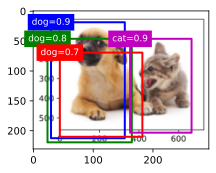

In [20]:
fig = d2l.plt.imshow(img)
'''
anchors: 归一化坐标 (x_min, y_min, x_max, y_max)，范围 [0, 1]
bbox_scale: 缩放因子（如图片宽度/高度）
作用：将归一化坐标转换为像素坐标，才能正确显示在图片上
'''
show_bboxes(fig.axes, anchors * bbox_scale,
            '''
            格式: ['类别=置信度', ...]
            数量: 4个标签，对应4个锚框
            内容:
            锚框0: dog=0.9（预测为狗，置信度0.9）
            锚框1: dog=0.8（预测为狗，置信度0.8）
            锚框2: dog=0.7（预测为狗，置信度0.7）
            锚框3: cat=0.9（预测为猫，置信度0.9）
            '''
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

返回结果的形状是（批量大小，锚框的数量，6）

| 参数              | 值           | 含义               |
| --------------- | ----------- | ---------------- |
| `cls_probs`     | `(1, 3, 4)` | 类别概率（含背景）        |
| `offset_preds`  | `(1, 16)`   | 预测的偏移量（全0）       |
| `anchors`       | `(1, 4, 4)` | 锚框坐标             |
| `nms_threshold` | `0.5`       | IoU ≥ 0.5 的框会被抑制 |


In [21]:
output = multibox_detection(cls_probs.unsqueeze(dim=0), 
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
# [类别, 置信度, x1, y1, x2, y2])
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

输出由非极大值抑制保存的最终预测边界框

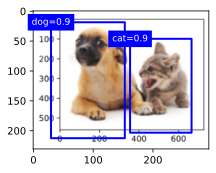

In [22]:
fig = d2l.plt.imshow(img)
'''
output:multibox_detection的输出，形状 (1,num_anchors,6)
output[0]:取出第一个批次，形状 (num_anchors,6)
.detach():分离计算图（不再跟踪梯度，转为NumPy加速遍历）
.numpy():转为NumPy数组，方便逐行迭代
i: 每行的数据，格式 [类别,置信度,x1,y1,x2,y2]
'''
for i in output[0].detach().numpy():
    '''
    i[0] 是 类别 ID
    == -1 表示背景（被 NMS 抑制或低置信度）
    continue 跳过不绘制，只显示有效目标
    '''
    if i[0] == -1:
        continue
    '''
    ('dog=', 'cat='):标签前缀元组
    索引 0 → 'dog='l；索引 1 → 'cat='
    int(i[0]): 将类别 ID 转为整数索引
    i[0] = 1 → int(i[0]) = 0 → 'dog=；i[0] = 2 → int(i[0]) = 1 → 'cat=
    str(i[1]): 取出置信度并转为字符串（如 '0.9'）
    结果: 'dog=0.9' 或 'cat=0.9'
    '''
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    '''
    fig.axes: 绘图坐标轴（之前显示图片时创建）
    i[2:]: 切片提取 4个坐标值 [x1, y1, x2, y2]
    torch.tensor(...): 转回张量以便运算
    * bbox_scale: 坐标放大（归一化 → 像素坐标）
    [...]: 包裹成列表，因为 show_bboxes 接受框列表
    label: 显示在框左上角的文本（如 'dog=0.9'）
    '''
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)